# Theory:

Compare timeseries with RC prediction

# Imports:

In [67]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Systems:

### Only 2 varaibles of the Lorenz System:

(100000, 2)


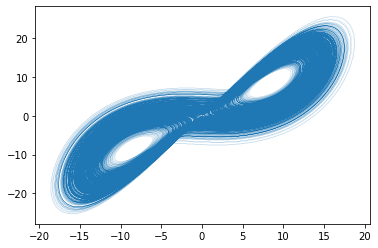

In [69]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 100000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series = time_series_all[disc_steps:, :]
time_series = time_series[:, 0:2]
plt.plot(time_series[:, 0], time_series[:, 1], linewidth=0.1)
print(time_series.shape)

### Noise:

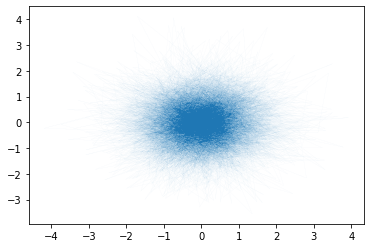

In [132]:
# noise:
time_series = np.random.randn(time_steps, 2)
plt.plot(time_series[:, 0], time_series[:, 1], linewidth=0.01)

### Clearly periodic System:

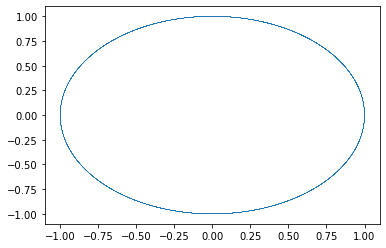

In [148]:
r = 5
time_steps = 10000
omega = 2*np.pi/500

alphas = np.arange(time_steps)*omega
x = np.sin(alphas)
y = np.cos(alphas)
time_series = np.stack([x, y]).T

plt.plot(time_series[:, 0], time_series[:, 1], linewidth=0.1)

# RC prediction:

In [149]:
esn = rescomp.ESNWrapper()
esn.create_architecture(1000, 2, w_out=None, seed=9, w_out_fit_flag="linear_and_square_r_alt", leak_fct=0.0,
                        activation_function="tanh", n_rad=0.4, w_in_scale=0.15, n_avg_deg=10)
esn.summary()

INPUT: 
x_dim: 2
INPUT-RESERVOIR COUPLING W_in: 
W_in: (1000, 2)
- - - - - - - - - - -
w_in_scale: 0.15, w_in_sparse: True, w_in_ordered: False
RESERVOIR: 
- - - - - - - - - - -
Network: 
n_dim: 1000
n_rad: 0.4, n_avg_deg: 10, n_type_flag: erdos_renyi, 
- - - - - - - - - - -
Dynamics: 
act_fct_flag: tanh, bias_scale: 0, leak_factor: 0.0
Update equation: r(i+1) = leak_fct * r(i) + (1-leak_fct) * act_fct(W_in * x(i) + W * r(i))
NON-LINEAR TRANSFORM OF RESERVOIR STATE: 
w_out_fit_flag: linear_and_square_r_alt
RESERVOIR-OUTPUT COUPLING W_out: 
W_out: (2, 1000)



In [150]:
# create w_out_init:
train_steps = 1000
sync_steps = 50

esn.reset_res_state()
# time_series=time_series[:, :1]
gamma = 0.0001
esn.train(x_train=time_series[:sync_steps + train_steps], sync_steps=sync_steps, reg_param=1e-12, w_in_no_update=True)
y_pred, y_test = esn.predict(time_series[sync_steps + train_steps-1:], save_r=False)

# Compare real vs. predicted time_series:

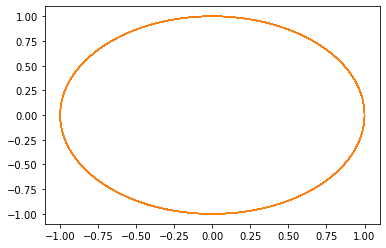

In [151]:
plt.plot(y_pred[:, 0], y_pred[:, 1], linewidth=1)
plt.plot(time_series[:, 0], time_series[:, 1], linewidth=1)

In [152]:
time = np.arange(0, y_pred.shape[0])*dt_L

## small times:

(0, 2)

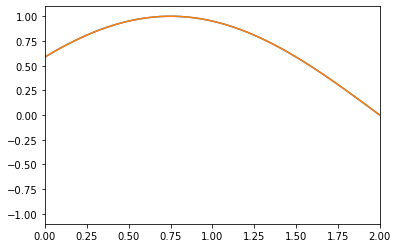

In [153]:
# Simple: plot some coordinates
ix = 0
plt.plot(time, y_test[:, ix])
plt.plot(time, y_pred[:, ix])

plt.xlim(0, 2)

(0, 15)

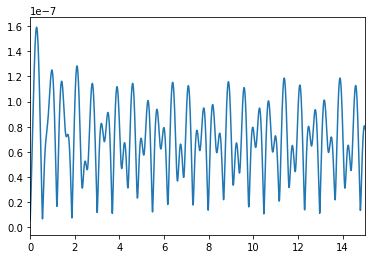

In [154]:
# plot the error over time:
error = rescomp.measures.error_over_time(y_pred, y_test)
plt.plot(time, error)
plt.xlim(0, 15)

## Attractor measures:

### Probability Density Function:

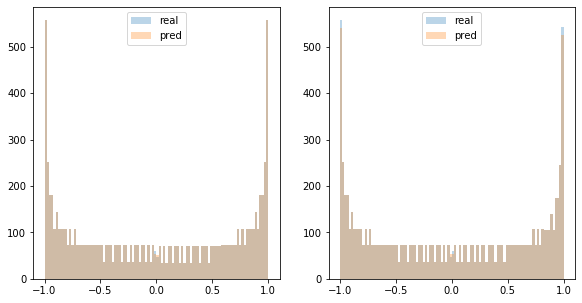

In [155]:
# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

# plt.subplot(133)
# ix = 2
# _, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
# plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
# plt.legend()

### Fourier Spectrum:

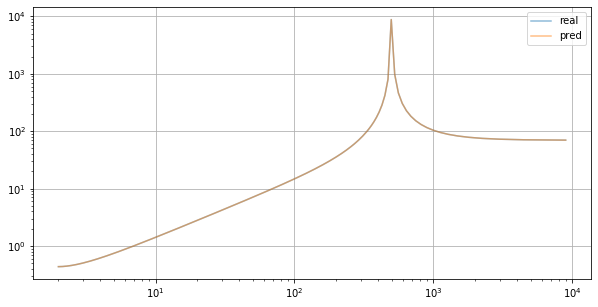

In [156]:
# Fourier Spectrum:
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(y_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(y_pred, period=True)
plt.plot(x,y, label="pred", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

### Poincare Map:

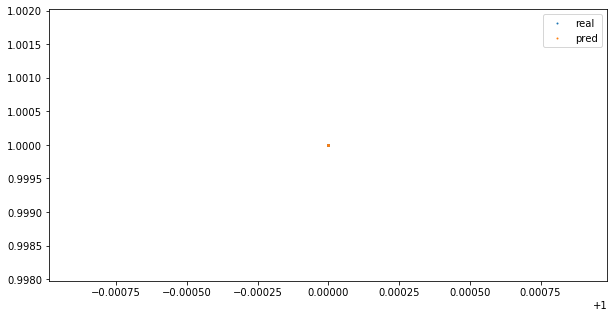

In [157]:
# Poincare Map:
ix = 1
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=1)

x, y = rescomp.measures.poincare_map(y_pred, dimension=ix, mode=mode)
plt.scatter(x, y, label="pred", s=1)

plt.legend()

### Correlation Dimension:

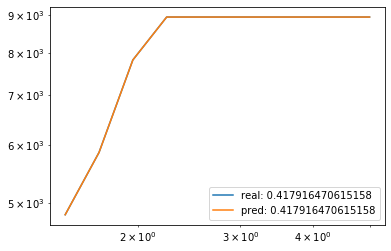

In [158]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"pred: {sloap}")

plt.legend()

### Lyapunov spectrum:

#### Rosenberg Algorithm:

avg period: 4.335630128985482
For 0/8950 points, all 50 closest neighbours were temporally closer than 4.335630128985482 and thus not considered
For 850/8950 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 8100
avg period: 4.335630208404845


C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\measures.py:947: RuntimeWarning: divide by zero encountered in log
  log_d = np.log(d_no_zero)


For 0/8950 points, all 50 closest neighbours were temporally closer than 4.335630208404845 and thus not considered
For 972/8950 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 7978


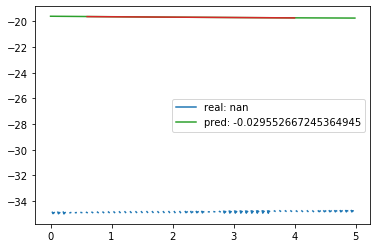

In [159]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(y_test, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(y_pred, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"pred: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

# What does the reservoir do on its own?


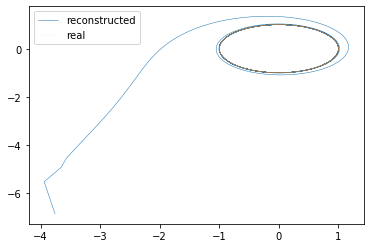

In [160]:
np.random.seed(10)
initial_res_state = np.random.randn(1000) * 100

esn.reset_res_state(initial_res_state)
y_pred_auto = esn.run_loop(5000, save_r=True)  # [100:]

plt.plot(y_pred_auto[:, 0], y_pred_auto[:, 1], linewidth=0.5, label="reconstructed")
plt.plot(y_test[:, 0], y_test[:, 1], linewidth=0.1, label="real", alpha=0.5)
plt.legend()
